# Daugiabučių renovacija Kaune

Data: 2019-12-03

Autrius: © 2019 Laurynas Varnas, https://www.linkedin.com/in/laurynas-varnas/.

## Analizė atsako į šiiuos klausimus:
1. [Keliais procentais vidutiniškai sumažėjo energijos sąnaudos po buto renovacijos?](#Keliais-procentais-vidutiniškai-sumažėjo-energijos-sąnaudos-po-buto-renovacijos?)
1. [Namo pastatymo metų ir vieno buto suvartojamos šilumos kiekio santykis.](#Namo-pastatymo-metų-ir-vieno-buto-suvartojamos-šilumos-kiekio-santykis)
1. [Ar žinant energijos sąnaudas galima nuspėti oro temperatūrą ir buto plotą?](#Ar-žinant-energijos-sąnaudas-galima-nuspėti-oro-temperatūrą-ir-buto-plotą?) (MM)
1. [Ar iš namo energijos sąnaudų, pastatymo metų bei lauko temperatūros galima pasakyti ar namas yra renovuotas? (Decision Trees)](#Decision-Trees) (MM2)
1. [Ar iš namo energijos sąnaudų, pastatymo metų bei lauko temperatūros galima pasakyti ar namas yra renovuotas? (Multi-layer Perceptron)](#Multi-layer-Perceptron) (MM2)
1. [Ar iš namo energijos sąnaudų, pastatymo metų bei lauko temperatūros galima pasakyti ar namas yra renovuotas? (Recurrent Neural Network)](#Recurrent-Neural-Network) (MM2)


## Pasitelkiami duomenų šaltiniai:
* https://github.com/Kauno-miestas/Daugiabuciu-renovacija

Šis sąsiuvinis yra platinamas pagal <a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/">Creative Commons Priskyrimas 4.0 Tarptautinė licenciją</a>. <img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-nc-sa/4.0/80x15.png" /></a>

Jis yra dalis atsiskaitymo [KTU IF](https://if.ktu.edu/) kurse [P176M010 "Pažangus mašininis mokymasis"](https://stojantiesiems.ktu.edu/programme/m-programu-sistemu-inzinerija/#P176M010), kurį veda [M. Lukoševičius](http://mantas.info/).

## Įsikeliame duomenis

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd
from sklearn import linear_model
import io, requests
from itertools import compress
import re

Nustatoma lokalė, nes duomenys lietuviški ir sveikosios dalies skyriklis yra kablelis.

In [2]:
import locale
locale.setlocale(locale.LC_ALL, "lt_LT");

Dėl duomenų pateikimo skirtumų kiekvienam mėnesiui reikia apibrėžti nuo kur skaityti duomenis.

In [3]:
men = ["7%20Gruodis", "7%20Lapkritis", "7%20Spalis", "8%20Kovas", "8%20Sausis", "8%20Vasaris"]

cordTemp = [(slice(4, None), 3), (slice(6, None), 3),
            (slice(6, None), 3), (slice(4, None), 4),
            (slice(7, None), 3), (slice(4, None), 4)]

cordRen =  [(slice(4, None), 8), (slice(6, None), 6),
            (slice(6, None), 6), (slice(4, None), 9),
            (slice(7, None), 8), (slice(4, None), 9)]

cordEn =   [(slice(4, None), 11), (slice(6, None), 9),
            (slice(6, None), 9), (slice(4, None), 12),
            (slice(7, None), 11), (slice(4, None), 12)]

cordS =    [(slice(4, None), 17), (slice(6, None), 15),
            (slice(6, None), 15), (slice(4, None), 18),
            (slice(7, None), 17), (slice(4, None), 18)]

cordApN =  [(slice(4, None), 9), (slice(6, None), 7),
            (slice(6, None), 7), (slice(4, None), 10),
            (slice(7, None), 9), (slice(4, None), 10)]

cordYear = [(slice(4, None), 10), (slice(6, None), 8),
            (slice(6, None), 8), (slice(4, None), 11),
            (slice(7, None), 10), (slice(4, None), 11)]

Duomenų nuskaitymas ir išrinkimas tik tai kas nodojama.

In [4]:
# renovuotų ir nerenovuotų namų energijos sąnaudų sąrašai
renA = []
norenA = []

energyPerAppartment = []    # vieno buto sunaudota energija
year = []                   # namų pastatymo metai

temp = []                   # temperatūros
appArea = []                # butų plotai
E = []                      # energijos sąnaudos

udf = pd.DataFrame()        # apdorotų duomenų lentelė

for m in zip(men, cordRen, cordEn, cordS, cordApN, cordYear, cordTemp):
    url = f"https://raw.githubusercontent.com/Kauno-miestas/Daugiabuciu-renovacija/master/%C5%A0ilumos%20suvartojimas%20daugiabu%C4%8Diuose/2017-2018m/Kaunas%20201{m[0]}.csv"
    s = requests.get(url).content
    df = pd.read_csv(io.StringIO(s.decode('utf-8')))

    isRen = [x is not np.nan for x in df.iloc[m[1]]]
    isnRen = [x is np.nan for x in df.iloc[m[1]]]
    energy = [locale.atof(x) for x in df.iloc[m[2]].dropna()]
    area = [locale.atof(x) for x in df.iloc[m[3]].dropna()]
    appN = [int(x) for x in df.iloc[m[4]].dropna()]
    year.extend([int(re.search("[0-9]+", x)[0]) for x in df.iloc[m[5]].dropna()])


    enPerArea = [x[0] / x[1] for x in zip(energy, area)]
    renA.extend(list(compress(enPerArea, isRen)))
    norenA.extend(list(compress(enPerArea, isnRen)))

    energyPerAppartment.extend([x[0] / x[1] for x in zip(energy, appN)])

    temp.extend([locale.atof(x) for x in df.iloc[m[6]].dropna()])
    E.extend(energy)
    appArea.extend(area)
    
    udf = pd.concat([udf, pd.DataFrame({'renovuotas': isRen, 'energija': df.iloc[m[2]], 'temperatura': df.iloc[m[6]], 'metai': df.iloc[m[5]]})])

udf = udf.dropna()
udf.temperatura = udf.temperatura.apply(lambda x: locale.atof(x))
udf.energija = udf.energija.apply(lambda x: locale.atof(x))
udf.metai = udf.metai.apply(lambda x: int(re.search("[0-9]+", x)[0]));

## Keliais procentais vidutiniškai sumažėjo energijos sąnaudos po buto renovacijos?

Renovuotiems daugiabučiams reikia beveik 2 kartus mažiau energijos.

In [5]:
np.mean(renA) / np.mean(norenA) * 100

48.44826971352078

## Namo pastatymo metų ir vieno buto suvartojamos šilumos kiekio santykis
Nauji namai yra efektyvesni energijos atžvilgiu.

<IPython.core.display.Javascript object>


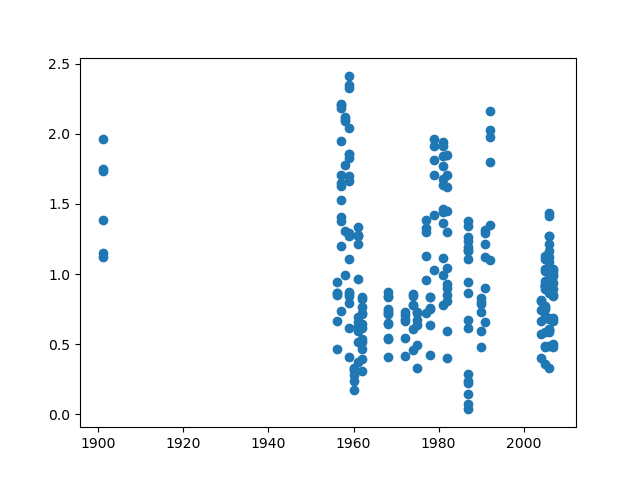

In [6]:
plt.scatter(udf.metai, energyPerAppartment);

## Ar žinant energijos sąnaudas galima nuspėti oro temperatūrą ir buto plotą?

Iš energijos sąnaudų galima nuspėti oro temperatūrą ir buto plotą.

<IPython.core.display.Javascript object>


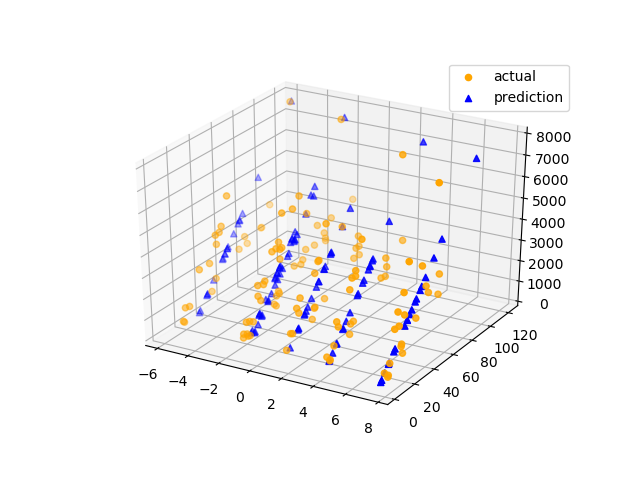

In [7]:
reg = linear_model.LinearRegression()
reg.fit(list(zip(temp[::2], appArea[::2])), E[::2])

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(xs=temp[1::2], ys=E[1::2], zs=appArea[1::2], c='orange', label='actual');

ax.scatter(xs=temp[1::2], ys=reg.predict(list(zip(temp[1::2], appArea[1::2]))), zs=appArea[1::2], c='b', marker='^', label='prediction');

ax.legend(loc='best', frameon=True);

# Ar iš namo energijos sąnaudų, pastatymo metų bei lauko temperatūros galima pasakyti ar namas yra renovuotas?

Duomenys apie namus:

In [8]:
udf.head(10)

renovuotas  energija  temperatura  metai
4         True       9.1          1.1   1987
5        False      50.5          1.1   2006
6        False      53.6          1.1   2005
7        False      25.2          1.1   2004
8        False     100.7          1.1   2007
9        False      21.9          1.1   2006
10       False      65.6          1.1   2005
11       False      39.4          1.1   2005
12       False      33.0          1.1   2007
13       False      23.9          1.1   2006

In [9]:
udf.describe(include='all')

renovuotas    energija  temperatura        metai
count         240  240.000000   240.000000   240.000000
unique          2         NaN          NaN          NaN
top         False         NaN          NaN          NaN
freq          210         NaN          NaN          NaN
mean          NaN   44.405787     0.566667  1977.850000
std           NaN   27.680473     4.323592    21.347748
min           NaN    2.220000    -5.800000  1901.000000
25%           NaN   21.312500    -1.800000  1961.000000
50%           NaN   41.155000    -0.250000  1978.500000
75%           NaN   61.450000     3.900000  1991.250000
max           NaN  121.000000     7.600000  2007.000000

In [10]:
X = list(zip(udf.energija, udf.temperatura, udf.metai))
Y = udf.renovuotas

n = 100

Xtrain = X[n:]
Ytrain = Y[n:]

Xtest = X[:n]
Ytest = Y[:n]

def test(prediction):
    c = 0
    for x in zip(Ytest, prediction):
        if (x[0] == x[1]):
            c += 1
    print(f"Tikslumas: {c / len(Ytest) * 100} %")

## Decision Trees

In [11]:
from sklearn import tree

clf = tree.DecisionTreeClassifier()
clf = clf.fit(Xtrain, Ytrain)

test(clf.predict(Xtest))

Tikslumas: 90.0 %


<IPython.core.display.Javascript object>


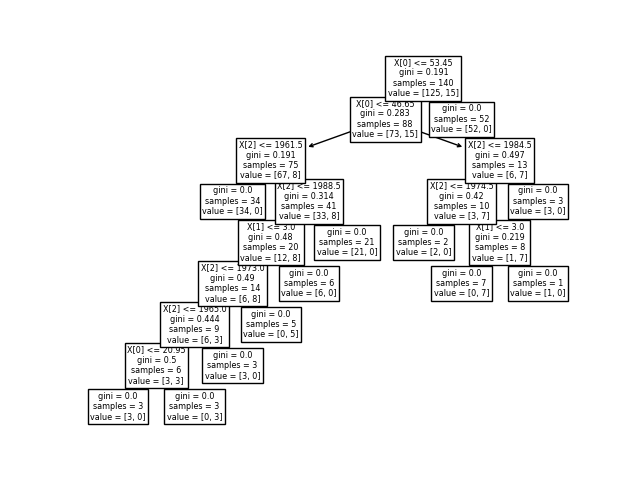

In [12]:
fig = plt.figure()
tree.plot_tree(clf);

## Multi-layer Perceptron

In [13]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)
clf = clf.fit(Xtrain, Ytrain)

test(clf.predict(Xtest))

Tikslumas: 85.0 %


# Recurrent Neural Network

In [14]:
import torch
from torch.autograd import Variable
import torch.nn.init as init

In [27]:
dtype = torch.FloatTensor
input_size, hidden_size, output_size = 6, 3, 1
epochs = 300
lr = 0.5

Ytrain = Variable(torch.Tensor([1.0 if y else 0.0 for y in Ytrain]).type(dtype), requires_grad=False)
Xtrain = Variable(torch.Tensor(Xtrain).type(dtype), requires_grad=False)
Xtest = Variable(torch.Tensor(Xtest).type(dtype), requires_grad=False)


In [28]:
w1 = torch.FloatTensor(input_size, hidden_size).type(dtype)
init.normal_(w1, 0.0, 0.4)
w1 = Variable(w1, requires_grad = True)
w2 = torch.FloatTensor(hidden_size, output_size).type(dtype)
init.normal_(w2, 0.0, 0.3)
w2 = Variable(w2, requires_grad = True)

In [31]:
def forward(x, context_state, w1, w2):
    xh = torch.cat((x, context_state), 1)
    context_state = torch.relu(xh.mm(w1))
    out = context_state.mm(w2)
    return (out, context_state)

In [32]:
for i in range(epochs):
    
    total_loss = 0
    context_state = Variable(torch.zeros((1, hidden_size)).type(dtype), requires_grad = True)

    for j in range(Xtrain.size(0)):
        x = Xtrain[j:(j+1)]
        y = Ytrain[j:(j+1)]
        
        (pred, context_state) = forward(x, context_state, w1, w2)
        loss = (pred - y).pow(2).sum()/2
        total_loss += loss
        loss.backward()
        w1.data -= lr * w1.grad.data
        w2.data -= lr * w2.grad.data
        w1.grad.data.zero_()
        w2.grad.data.zero_()
        context_state = Variable(context_state.data)
    if i % 10 == 0:
        print(f"Epoch: {i} loss {total_loss.item()}")

context_state = Variable(torch.zeros((1, hidden_size)).type(dtype), requires_grad = False)
predictions = []

for i in range(Xtest.size(0)):
    x = Xtest[i:i+1]
    (pred, context_state) = forward(x, context_state, w1, w2)
    context_state = context_state
    predictions.append(pred.data.numpy().ravel()[0])


Epoch: 0 loss 12471.345703125
Epoch: 10 loss 7.5
Epoch: 20 loss 7.5
Epoch: 30 loss 7.5
Epoch: 40 loss 7.5
Epoch: 50 loss 7.5
Epoch: 60 loss 7.5
Epoch: 70 loss 7.5
Epoch: 80 loss 7.5
Epoch: 90 loss 7.5
Epoch: 100 loss 7.5
Epoch: 110 loss 7.5
Epoch: 120 loss 7.5
Epoch: 130 loss 7.5
Epoch: 140 loss 7.5
Epoch: 150 loss 7.5
Epoch: 160 loss 7.5
Epoch: 170 loss 7.5
Epoch: 180 loss 7.5
Epoch: 190 loss 7.5
Epoch: 200 loss 7.5
Epoch: 210 loss 7.5
Epoch: 220 loss 7.5
Epoch: 230 loss 7.5
Epoch: 240 loss 7.5
Epoch: 250 loss 7.5
Epoch: 260 loss 7.5
Epoch: 270 loss 7.5
Epoch: 280 loss 7.5
Epoch: 290 loss 7.5


In [33]:
test(predictions)

Tikslumas: 85.0 %


## Išvados
   Dėl mažo duomenų kiekio neuroniniai tinklai pilnai neapsimoko, kas lemia prastesnius rezultatus lyginant su paprastesniu algoritmu.
   
   Šio darbo metu išmokau dirbti su pandas, sklearn, pytorch, susipažinau su mašininio mokymo tipais ir kaip juos realizuoti.